In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as datetime



from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, RandomForestClassifier, BaggingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score

from sklearn.model_selection import RandomizedSearchCV, train_test_split
import shap
import lightgbm as lgb 

pd.set_option('max_colwidth', 80)

In [2]:
df = pd.read_csv('final_data.csv') 
df.head()

TARGET_FID  Length  Install_year  Arterial_class  Surface_width  \
0           1  314.79          1972             2.0           40.0   
1           2  363.39          1972             0.0           46.0   
2           3  323.51          1972             0.0           46.0   
3           4  329.13          1928             0.0            0.0   
4           5  273.64          1928             2.0           42.0   

   Speed_limit  Slope  Width  Break_Yr  Target  ...  Surface_type_   \
0         25.0    0.0    8.0       NaN       0  ...               0   
1         20.0    4.0    8.0       NaN       0  ...               0   
2         20.0    4.0    8.0       NaN       0  ...               0   
3         20.0    6.0   12.0       NaN       0  ...               0   
4         25.0    4.0   18.0       NaN       0  ...               0   

   Surface_type_AC  Surface_type_AC/AC  Surface_type_AC/PCC  \
0                0                   0                    0   
1                1                   0                    0   
2                1                   0                    0   
3                0                   0                    0   
4                0                   0                    1   

   Surface_type_GRAVEL  Surface_type_PCC  Surface_type_ST  AGE  \
0                    0                 1                0   38   
1                    0                 0                0   38   
2                    0                 0                0   38   
3                    0                 0                1   82   
4                    0                 0                0   82   

   Nearby_breaks_1yr  Process_year  
0                  0          2010  
1                  0          2010  
2                  0          2010  
3                  0          2010  
4                  0          2010  

[5 rows x 56 columns]

In [3]:
df['Target'].unique()

array([0, 1])

In [4]:
df_2014 = df[df['Process_year'] == 2014]
df_2014.shape

(68274, 56)

In [5]:
df_2014['Break_Yr'].unique()

array([  nan, 2014.])

In [6]:
columns = df_2014.columns.drop(['TARGET_FID', 'Process_year', 'Break_Yr'])
df_2014_cols = df_2014[columns]
print(df_2014_cols.shape)
#df_2014_cols_cleaned = df_2014_cols[~df_2014_cols.isin([np.nan, np.inf, -np.inf]).any(1)].astype(np.float32) # removes rows with nan or inf points
df_2014_cols_cleaned = df_2014_cols.dropna(axis=0).astype(np.float32) # removes rows with nan or inf points
print(df_2014_cols_cleaned.shape)


(68274, 53)
(58917, 53)


In [7]:
features_df = df_2014_cols_cleaned.drop('Target', axis=1)
target_df = df_2014_cols_cleaned[['Target']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2)

In [17]:
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)


ExtraTreesClassifier()

In [21]:
preds = etc.predict(X_test)
probs = etc.predict_proba(X_test)
bal_acc = balanced_accuracy_score(y_pred=preds, y_true=y_test)
recall = recall_score(y_true=y_test, y_pred=preds)
precision = precision_score(y_true=y_test, y_pred=preds)
print(bal_acc)
print(recall)
print(precision)

0.6632526992148443
0.32727272727272727
0.6666666666666666


In [19]:
confusion_matrix(y_test, preds)

array([[11720,     9],
       [   37,    18]])

array([ 6,  0,  1, 50,  5,  3, 51,  2,  4, 21, 28, 48, 29, 44, 30, 40, 12,
       46, 49, 24, 32, 33, 41, 45, 23, 15, 16, 43, 11,  9, 10, 19, 17, 47,
       39, 35, 31, 34, 13, 37,  7, 26, 22, 36, 14, 25, 20, 18, 38,  8, 42,
       27])

In [79]:
def tree_feature_importance(tree_model, X_train):
    """
    Takes in a tree model and a df of training data and prints out
    a ranking of the most important features and a bar graph of the values
    
    Parameters
    ----------
    tree_model: the trained model instance. Must have feature_importances_ and estimators_ attributes
    X_train: DataFrame that the model was training on

    Returns
    -------
    This function currently does not return any values, but that may change
    """
    importances = tree_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree_model.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    features = X_train.columns.to_list()

    # Print the feature ranking
    print("Feature ranking:")
    print()
    for f in range(X_train.shape[1]):
        #feature_name = features[indices[f]]
        print(f'{f + 1}. {features[indices[f]]}, {importances[indices[f]]}')
        print()

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:

1. Width, 0.41127068260896044

2. Length, 0.16036928007185816

3. Install_year, 0.07894626955876584

4. AGE, 0.07795023708957519

5. Slope, 0.07534278278738074

6. Surface_width, 0.07179939972446514

7. Nearby_breaks_1yr, 0.023487841146831886

8. Arterial_class, 0.016406154037195347

9. Speed_limit, 0.0131050465897458

10. Material_Reinforced Concrete Pipe, 0.008347523164559546

11. Soil_type_3055, 0.006513621284116658

12. Surface_type_PCC, 0.006511664915141809

13. Soil_type_3056, 0.006303619992180426

14. Surface_type_AC, 0.00568853887152701

15. Soil_type_3057, 0.005462853485644473

16. Soil_type_988, 0.00528305118439069

17. Material_Concrete, 0.005221743443357269

18. Surface_type_AC/PCC, 0.005208904282169374

19. Surface_type_ST, 0.004173464102766697

20. Material_Vitrified Clay, 0.0027834948524673897

21. Soil_type_3059, 0.002244654756499338

22. Soil_type_3060, 0.002006759005428851

23. Soil_type_989, 0.0012470316553099498

24. Surface_type_AC/AC, 0.000661660

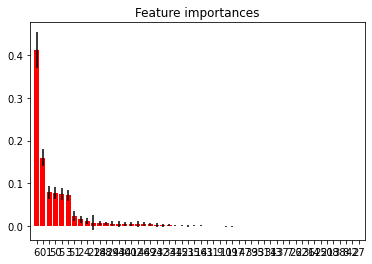

In [80]:
tree_feature_importance(etc, X_train)

In [82]:
explainer = shap.TreeExplainer(etc)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

KeyboardInterrupt: 